## Introduction and Cleaning Process

In run.py file, the vehicle stop data files from 2014 to June 2018 are extracted from https://data.sandiego.gov/datasets/police-vehicle-stops/ with the old format. The cleaning process for these data are as follow:
-	Race: races are grouped into “Asian”,  “Black/African American”,  “While”,  “Hispanic/Latino/a”,  “Middle Eastern or South Asian”,  and “Pacific Islander”.
-	Area Code: a new column named “division” is created, which group the area code into “Northern”, “Northeastern”, “Eastern”, “Southeastern”, “Central”, “Western”, “Southern”, “Mid-City”, and “Northwestern”.
-	Subject Age: subjects except ages between 14 and 99 are given a null value.
-	Data time: a new column named “timestamp” is created to process the data time.
-	Searched; searched are changed to binary values.
-	SD resident: whether or not subject is a SD resident is changed to a binary values.

Data from July 2018 to 2019 are extracted from https://data.sandiego.gov/datasets/police-ripa-stops/ with the new format. More details of the stop information are extracted from other files and merged together. The final table keeps only columns 'stop_id', 'reason_for_stop', 'beat', 'race', 'gend', 'perceived_age', 'date_stop', 'time_stop', 'action', 'result', 'basisforpropertyseizure'. 

In this report, only data from 2014 to June 2018 is processed and analyzed. 



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib
from datetime import *
warnings.filterwarnings("ignore")

In [2]:
#df14 = pd.read_csv('http://seshat.datasd.org/pd/vehicle_stops_2014_datasd_v1.csv')
#df15 = pd.read_csv('http://seshat.datasd.org/pd/vehicle_stops_2015_datasd_v1.csv')
#df16 = pd.read_csv('http://seshat.datasd.org/pd/vehicle_stops_2016_datasd_v1.csv')
df17 = pd.read_csv('http://seshat.datasd.org/pd/vehicle_stops_2017_datasd_v1.csv')
#df19 = pd.read_csv('http://seshat.datasd.org/pd/ripa_stops_datasd_v1.csv')

## EDA


In [3]:
df17.groupby('searched').count()

#df17.groupby('service_area').size()

#df17.date_time.isna().sum()

df17.head()

stop_id           stop_cause service_area subject_race subject_sex  \
0  1444799     Moving Violation          120            I           M   
1  1444821  Equipment Violation          520            W           M   
2  1447102     Moving Violation          520            W           M   
3  1444801  Equipment Violation          720            H           F   
4  1444802  Equipment Violation          120            H           M   

  subject_age            date_time   date_stop time_stop sd_resident arrested  \
0          37  2017-01-01 00:03:00  2017-01-01  00:03:00           N        N   
1          22  2017-01-01 00:25:00  2017-01-01  00:25:00           N        N   
2          29  2017-01-01 01:45:00  2017-01-01  01:45:00           N        N   
3          61  2017-01-01 03:10:00  2017-01-01  03:10:00           N        N   
4          24  2017-01-01 03:30:00  2017-01-01  03:30:00           Y        N   

  searched obtained_consent contraband_found property_seized  
0        N              NaN              NaN             NaN  
1        N              NaN              NaN             NaN  
2        N              NaN              NaN             NaN  
3        N              NaN              NaN             NaN  
4        N              NaN              NaN             NaN

In [4]:
'''
features = ['actions_taken', 'prop_seize_basis', 'race', 'search_basis', 'stop_reason', 'stop_result']
for i in features:
    table = pd.read_csv(('http://seshat.datasd.org/pd/ripa_{}_datasd.csv').format(i))
    df19 = df19.merge(table, on=['stop_id', 'pid'])
    
df19 = df19[['stop_id', 'reason_for_stop', 'beat', 'race', 'gend', 'perceived_age', 'date_stop', 'time_stop', 'action', 'result', 'basisforpropertyseizure']]
'''

"\nfeatures = ['actions_taken', 'prop_seize_basis', 'race', 'search_basis', 'stop_reason', 'stop_result']\nfor i in features:\n    table = pd.read_csv(('http://seshat.datasd.org/pd/ripa_{}_datasd.csv').format(i))\n    df19 = df19.merge(table, on=['stop_id', 'pid'])\n    \ndf19 = df19[['stop_id', 'reason_for_stop', 'beat', 'race', 'gend', 'perceived_age', 'date_stop', 'time_stop', 'action', 'result', 'basisforpropertyseizure']]\n"

In [5]:
def impute_target(stops):
    def impute(searched):
        p = searched.mean()
        return searched.apply(
            lambda x: np.random.choice([0, 1], p=[1 - p, p]) if pd.isnull(x) else x
        )
    searched = (
        stops
        .fillna({'service_area': 'NULL'})
        .groupby('service_area')
        .searched
        .apply(impute)
    )
    return stops.assign(searched=searched)


def clean_binary_cols(x):
    if x in ['Y', 'y']:
        return 1
    elif x in ['N', 'n']:
        return 0
    else:
        return np.NaN

In [6]:
#df = pd.concat([df14, df15, df16, df17])
df = df17

#clean race
race_code = {'A':'Asian', 'B':'Black/African American', 'C':'Asian', 'D':'Asian', 'F':'Asian', 'G':'Pacific Islander', 'H':'Hispanic/Latino/a', 'I':'Middle Eastern or South Asian', 'J':'Asian', 'K':'Asian', 'L':'Asian', 'O':np.nan, 'P':'Pacific Islander', 'S':'Pacific Islander', 'U':'Pacific Islander', 'V':'Asian', 'X':np.nan, 'Z':'Middle Eastern or South Asian', 'W':'White'}
df = df.replace({'subject_race': race_code})
df = df.dropna(subset=['subject_race', 'date_time'])

#service area
area_code = {'110':'Northern', '120':'Northern', '130':'Northern',
            '230':'Northeastern', '240':'Northeastern',
            '310':'Eastern', '320':'Eastern',
            '430':'Southeastern', '440':'Southeastern',
            '510':'Central', '520':'Central', '530':'Central',
            '610':'Western', '620':'Western', '630':'Western',
            '710':'Southern', '720':'Southern',
            '810':'Mid-City', '820':'Mid-City', '830':'Mid-City', '840':'Mid-City',
            '930':'Northwestern',
            'Unknown':np.nan}
df['division'] = df['service_area']
df = df.replace({'division': area_code})

#age
df['subject_age'] = pd.to_numeric(df['subject_age'], errors='coerce')
df['subject_age'] = df.subject_age.apply(lambda x: np.NaN if ((float(x) < 14) | (float(x) > 99)) else x)

#date time
#df['timestamp'] = pd.to_datetime(df['date_time'], errors='coerce')
df['timestamp'] = df['date_time'].dropna().apply(lambda x:datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

#searched
#resident
df['searched'] = df.searched.apply(clean_binary_cols)
df['sd_resident'] = df.sd_resident.apply(clean_binary_cols)

## Stop Race Rate vs. Population Race Rate

The census data is from https://web.archive.org/web/20120802190059/http://quickfacts.census.gov/qfd/states/06/0666000.html. The average estimated population rate from 2014-2019 is calculated in “census” table. The stop race rate and San Diego population race rate is compared in the bar graph below. 

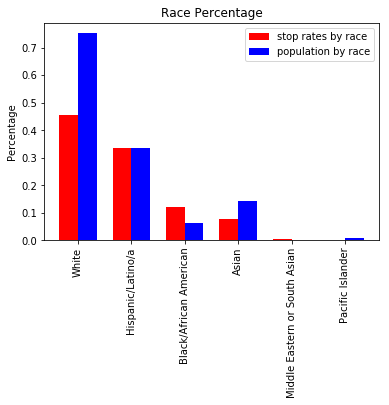

In [7]:
census = pd.DataFrame({'2018':{'White':0.755,'Black/African American':0.065,'Hispanic':0.34,
                      'Native American':0.014,'Asian':0.148,'Pacific Islander':0.01},
            '2017':{'White':0.743,'Black/African American':0.064,'Hispanic':0.339,
                      'Native American':0.017,'Asian':0.148,'Pacific Islander':0.01},
             '2016':{'White':0.763,'Black/African American':0.063,'Hispanic':0.335,
                      'Native American':0.016,'Asian':0.143,'Pacific Islander':0.011},
             '2015':{'White':0.748,'Black/African American':0.062,'Hispanic':0.334,
                      'Native American':0.014,'Asian':0.142,'Pacific Islander':0.01},
             '2014':{'White':0.753,'Black/African American':0.064,'Hispanic':0.332,
                      'Native American':0.016,'Asian':0.14,'Pacific Islander':0.01}}).mean(axis=1)

stop_r = df.subject_race.value_counts()/df.shape[0]

labels = list(stop_r.index)
count = stop_r.values
race = [census[5],census[2],census[1],census[0],0,census[4]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, count, width, label='stop rates by race', color='red')
rects2 = ax.bar(x + width/2, race, width, label='population by race', color='blue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Race Percentage')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.xticks(rotation=90)
plt.show()

From the bar graph above, Hispanic and Black drivers can be seen to have a higher chance of being stopped even with small populations. Therefore, from a general glance, a disparity of drivers’ races by the police officers could be assumed. 

## Service Area General Analysis

When group the vehicle data by service area/division, a difference between the race of drivers stopped in different division can be observed. 

The first table displays the percentages of stops in different divisions by race, which the second table displays the percentage of races stopped in different division. For example, the first table shows that black drivers are more likely to be stopped in Southeastern San Diego (approximately 22.5% of them) than in Northern San Diego (approximately 2.7% of them). The second table shows that in Southeastern San Diego, stopped drivers are much less likely to be white (approximately 11.5%) than in Northwestern San Diego (approximately 60.9%). Therefore, service area/divisions could be a factor than affect the stop race rate.  


In [8]:
#service area analysis
temp = df.groupby(['subject_race','division']).size()
d1 = temp / temp.groupby(level=0).sum()
d1.to_frame()#.to_csv('by_race.csv')
#by_race = pd.read_csv('by_race.csv')
#by_race

0
subject_race                  division              
Asian                         Central       0.053337
                              Eastern       0.214465
                              Mid-City      0.083357
                              Northeastern  0.263195
                              Northern      0.128316
                              Northwestern  0.087685
                              Southeastern  0.072605
                              Southern      0.045518
                              Western       0.051522
Black/African American        Central       0.148779
                              Eastern       0.165087
                              Mid-City      0.160897
                              Northeastern  0.063138
                              Northern      0.084366
                              Northwestern  0.022686
                              Southeastern  0.245171
                              Southern      0.048196
                              Western       0.061680
Hispanic/Latino/a             Central       0.133048
                              Eastern       0.114137
                              Mid-City      0.093822
                              Northeastern  0.055298
                              Northern      0.087841
                              Northwestern  0.029737
                              Southeastern  0.116576
                              Southern      0.317451
                              Western       0.052090
Middle Eastern or South Asian Central       0.057214
                              Eastern       0.144279
                              Mid-City      0.019900
                              Northeastern  0.248756
                              Northern      0.124378
                              Northwestern  0.283582
                              Southeastern  0.017413
                              Southern      0.024876
                              Western       0.079602
Pacific Islander              Central       0.051613
                              Eastern       0.174194
                              Mid-City      0.193548
                              Northeastern  0.051613
                              Northern      0.122581
                              Northwestern  0.103226
                              Southeastern  0.129032
                              Southern      0.122581
                              Western       0.051613
White                         Central       0.115461
                              Eastern       0.212995
                              Mid-City      0.061779
                              Northeastern  0.126436
                              Northern      0.240945
                              Northwestern  0.076632
                              Southeastern  0.018804
                              Southern      0.046950
                              Western       0.099998

In [9]:
temp1 = df.groupby(['division', 'subject_race']).size()
d2 = temp1 / temp1.groupby(level=0).sum()
d2.to_frame()#.to_csv('out.csv')
#by_division = pd.read_csv('by_division.csv')
#by_division

0
division     subject_race                           
Central      Asian                          0.035495
             Black/African American         0.151738
             Hispanic/Latino/a              0.370006
             Middle Eastern or South Asian  0.002137
             Pacific Islander               0.000743
             White                          0.439881
Eastern      Asian                          0.098575
             Black/African American         0.116288
             Hispanic/Latino/a              0.219227
             Middle Eastern or South Asian  0.003722
             Pacific Islander               0.001733
             White                          0.560454
Mid-City     Asian                          0.077112
             Black/African American         0.228106
             Hispanic/Latino/a              0.362697
             Middle Eastern or South Asian  0.001033
             Pacific Islander               0.003875
             White                          0.327176
Northeastern Asian                          0.197900
             Black/African American         0.072756
             Hispanic/Latino/a              0.173753
             Middle Eastern or South Asian  0.010499
             Pacific Islander               0.000840
             White                          0.544252
Northern     Asian                          0.063722
             Black/African American         0.064207
             Hispanic/Latino/a              0.182291
             Middle Eastern or South Asian  0.003467
             Pacific Islander               0.001317
             White                          0.684995
Northwestern Asian                          0.124628
             Black/African American         0.049415
             Hispanic/Latino/a              0.176622
             Middle Eastern or South Asian  0.022624
             Pacific Islander               0.003175
             White                          0.623536
Southeastern Asian                          0.069352
             Black/African American         0.358896
             Hispanic/Latino/a              0.465324
             Middle Eastern or South Asian  0.000934
             Pacific Islander               0.002667
             White                          0.102827
Southern     Asian                          0.026483
             Black/African American         0.042973
             Hispanic/Latino/a              0.771812
             Middle Eastern or South Asian  0.000812
             Pacific Islander               0.001543
             White                          0.156377
Western      Asian                          0.054707
             Black/African American         0.100371
             Hispanic/Latino/a              0.231134
             Middle Eastern or South Asian  0.004744
             Pacific Islander               0.001186
             White                          0.607858

## Stop Age General Analysis

The stopped driver’s ages has a right-skewed distribution with a center at around 25 years old. The histogram shows that the age data could not be precise as they show spikes at 5 and 10 years gap. This affect could due to police officers’ misfiling of information. For example, if the subject is 29 years old, the police officers tend to record the age as 30 instead. However, the age variable is irrelevant of the report’s analysis of race disparity. Therefore, the ages are only cleaned to the extent that the subjects ages not between 14-99 are filled with null value. 







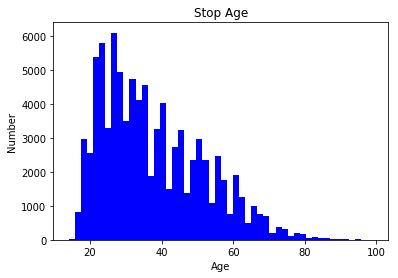

In [10]:
ax = df['subject_age'].plot(kind='hist', title='Stop Age', bins=50, color='blue')
ax.set_xlabel('Age')
ax.set_ylabel('Number')
plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df.head()

stop_id           stop_cause service_area                   subject_race  \
0  1444799     Moving Violation          120  Middle Eastern or South Asian   
1  1444821  Equipment Violation          520                          White   
2  1447102     Moving Violation          520                          White   
3  1444801  Equipment Violation          720              Hispanic/Latino/a   
4  1444802  Equipment Violation          120              Hispanic/Latino/a   

  subject_sex  subject_age            date_time   date_stop time_stop  \
0           M         37.0  2017-01-01 00:03:00  2017-01-01  00:03:00   
1           M         22.0  2017-01-01 00:25:00  2017-01-01  00:25:00   
2           M         29.0  2017-01-01 01:45:00  2017-01-01  01:45:00   
3           F         61.0  2017-01-01 03:10:00  2017-01-01  03:10:00   
4           M         24.0  2017-01-01 03:30:00  2017-01-01  03:30:00   

   sd_resident arrested  searched obtained_consent contraband_found  \
0          0.0        N       0.0              NaN              NaN   
1          0.0        N       0.0              NaN              NaN   
2          0.0        N       0.0              NaN              NaN   
3          0.0        N       0.0              NaN              NaN   
4          1.0        N       0.0              NaN              NaN   

  property_seized  division           timestamp  
0             NaN  Northern 2017-01-01 00:03:00  
1             NaN   Central 2017-01-01 00:25:00  
2             NaN   Central 2017-01-01 01:45:00  
3             NaN  Southern 2017-01-01 03:10:00  
4             NaN  Northern 2017-01-01 03:30:00

## Post-stop Outcomes (Searched)

The post-stop outcome – whether or not the stopped driver is being searched, is analyzed. The table displays a disparity between race from vehicle stops from 2014 to June 2018. For example, when a black driver is being stopped, he/she has an approximately 9.02% chance of being searched, while a white drive has an approximately 2.56% chance of being searched. 

In [13]:
race_rate = df.subject_race.value_counts()/len(df)
searched_rate = df.groupby('subject_race').sum()['searched'] / df.subject_race.value_counts()
pd.DataFrame({'searched rate percentage': searched_rate*100})

searched rate percentage
Asian                                          1.926730
Black/African American                         8.531973
Hispanic/Latino/a                              4.480808
Middle Eastern or South Asian                  1.216545
Pacific Islander                               7.547170
White                                          3.258488

In [32]:
race_rate = df.subject_race.value_counts()/len(df)
arrested_rate = df.groupby('subject_race').count()['arrested'] / df.subject_race.value_counts()
pd.DataFrame({'arrested rate percentage': arrested_rate})

arrested rate percentage
Asian                                          0.824830
Black/African American                         0.834198
Hispanic/Latino/a                              0.787593
Middle Eastern or South Asian                  0.812652
Pacific Islander                               0.805031
White                                          0.845746

In [34]:
race_rate = df.subject_race.value_counts()/len(df)
contraband_found_rate = df.groupby('subject_race').count()['contraband_found'] / df.subject_race.value_counts()
pd.DataFrame({'contraband found rate percentage': contraband_found_rate})

contraband found rate percentage
Asian                                                  0.023609
Black/African American                                 0.070982
Hispanic/Latino/a                                      0.045703
Middle Eastern or South Asian                          0.026764
Pacific Islander                                       0.088050
White                                                  0.036001

In [39]:
race_rate = df.subject_race.value_counts()/len(df)
contraband_found_rate = df.groupby('subject_race').count()['contraband_found'] / df.groupby('subject_race').count()['searched']
pd.DataFrame({'contraband found rate percentage': contraband_found_rate*100})

contraband found rate percentage
subject_race                                                   
Asian                                                  2.887967
Black/African American                                 8.651372
Hispanic/Latino/a                                      5.885743
Middle Eastern or South Asian                          3.293413
Pacific Islander                                      10.852713
White                                                  4.297446

In [40]:
race_rate = df.subject_race.value_counts()/len(df)
property_seized_rate = df.groupby('subject_race').count()['property_seized'] / df.groupby('subject_race').count()['searched']
pd.DataFrame({'property seized rate percentage': property_seized_rate*100})

property seized rate percentage
subject_race                                                  
Asian                                                 2.904564
Black/African American                                8.458405
Hispanic/Latino/a                                     5.848699
Middle Eastern or South Asian                         3.293413
Pacific Islander                                     10.852713
White                                                 4.280571

# VoD

In [15]:
df.head()

stop_id           stop_cause service_area                   subject_race  \
0  1444799     Moving Violation          120  Middle Eastern or South Asian   
1  1444821  Equipment Violation          520                          White   
2  1447102     Moving Violation          520                          White   
3  1444801  Equipment Violation          720              Hispanic/Latino/a   
4  1444802  Equipment Violation          120              Hispanic/Latino/a   

  subject_sex  subject_age            date_time   date_stop time_stop  \
0           M         37.0  2017-01-01 00:03:00  2017-01-01  00:03:00   
1           M         22.0  2017-01-01 00:25:00  2017-01-01  00:25:00   
2           M         29.0  2017-01-01 01:45:00  2017-01-01  01:45:00   
3           F         61.0  2017-01-01 03:10:00  2017-01-01  03:10:00   
4           M         24.0  2017-01-01 03:30:00  2017-01-01  03:30:00   

   sd_resident arrested  searched obtained_consent contraband_found  \
0          0.0        N       0.0              NaN              NaN   
1          0.0        N       0.0              NaN              NaN   
2          0.0        N       0.0              NaN              NaN   
3          0.0        N       0.0              NaN              NaN   
4          1.0        N       0.0              NaN              NaN   

  property_seized  division           timestamp  
0             NaN  Northern 2017-01-01 00:03:00  
1             NaN   Central 2017-01-01 00:25:00  
2             NaN   Central 2017-01-01 01:45:00  
3             NaN  Southern 2017-01-01 03:10:00  
4             NaN  Northern 2017-01-01 03:30:00

In [16]:
t_17 = pd.read_csv('twilight.csv').loc[:364]
t_18 = pd.read_csv('twilight.csv').loc[365:]
t_17['Day'] = t_17['Day'].apply(lambda x:x+' 2017')
t_18['Day'] = t_18['Day'].apply(lambda x:x+' 2018')
t_17['Sunset'] = t_17['Day'] + ' ' + t_17['Sunset']
t_17['Dusk'] = t_17['Day'] + ' ' + t_17['End']
t_18['Sunset'] = t_18['Day'] + ' ' + t_18['Sunset']
t_18['Dusk'] = t_18['Day']+' '+t_18['End']
t_17.drop(columns = ['Day', 'End'], inplace=True)
t_18.drop(columns = ['Day', 'End'], inplace=True)
t_17 = t_17.applymap(lambda x:datetime.strptime(x, '%a, %b %d %Y %I:%M:%S %p'))
t_18 = t_18.applymap(lambda x:datetime.strptime(x, '%a, %b %d %Y %I:%M:%S %p'))
twilight = t_17.append(t_18)
twilight['date_stop'] = twilight['Sunset'].apply(lambda x:datetime.date(x)).astype(str)

In [2]:
def find_percentage(file_path)
    t_17 = pd.read_csv(file_path).loc[:364]
    t_18 = pd.read_csv(file_path).loc[365:]
    t_17['Day'] = t_17['Day'].apply(lambda x:x+' 2017')
    t_18['Day'] = t_18['Day'].apply(lambda x:x+' 2018')
    t_17['Sunset'] = t_17['Day'] + ' ' + t_17['Sunset']
    t_17['Dusk'] = t_17['Day'] + ' ' + t_17['End']
    t_18['Sunset'] = t_18['Day'] + ' ' + t_18['Sunset']
    t_18['Dusk'] = t_18['Day']+' '+t_18['End']
    t_17.drop(columns = ['Day', 'End'], inplace=True)
    t_18.drop(columns = ['Day', 'End'], inplace=True)
    t_17 = t_17.applymap(lambda x:datetime.strptime(x, '%a, %b %d %Y %I:%M:%S %p'))
    t_18 = t_18.applymap(lambda x:datetime.strptime(x, '%a, %b %d %Y %I:%M:%S %p'))
    twilight = t_17.append(t_18)
    twilight['date_stop'] = twilight['Sunset'].apply(lambda x:datetime.date(x)).astype(str)
    vod = df.merge(twilight, on='date_stop')
    #datetime to string (take 'time' only)
    vod.Sunset = vod.Sunset.apply(lambda x: datetime.strftime(x, '%H:%M:%S'))
    vod.Dusk = vod.Dusk.apply(lambda x: datetime.strftime(x, '%H:%M:%S'))
    vod['stop'] = vod.timestamp.apply(lambda x: datetime.strftime(x, '%H:%M:%S'))
    #tring to datatime (make all the years the same to compare time)
    vod.Sunset = vod.Sunset.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
    vod.Dusk = vod.Dusk.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
    vod.stop = vod.stop.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
    #chosen inter-twilight period
    set_start = datetime(1900, 1, 1, 18, 45, 0)
    set_stop = datetime(1900, 1, 1, 19, 0, 0)
    #Stop time is between the chosen period
    vod = vod[vod.stop >= set_start]
    vod = vod[vod.stop <= set_stop]

    #Stop time is NOT between the inter-twilight period of that day (should be neither dark or bright)
    bright = vod[list(vod.stop <= vod.Sunset)]
    dark = vod[list(vod.stop >= vod.Dusk)]

    #Whether the stop time is before sunset or not (bright or not)
    #vod['Bright'] = list(vod.stop <= vod.Sunset)


    (bright.subject_race == 'Black/African American').mean()


    (dark.subject_race == 'Black/African American').mean()

FileNotFoundError: [Errno 2] File twilight.csv does not exist: 'twilight.csv'

In [18]:
vod.head()

stop_id           stop_cause service_area                   subject_race  \
0  1444799     Moving Violation          120  Middle Eastern or South Asian   
1  1444821  Equipment Violation          520                          White   
2  1447102     Moving Violation          520                          White   
3  1444801  Equipment Violation          720              Hispanic/Latino/a   
4  1444802  Equipment Violation          120              Hispanic/Latino/a   

  subject_sex  subject_age            date_time   date_stop time_stop  \
0           M         37.0  2017-01-01 00:03:00  2017-01-01  00:03:00   
1           M         22.0  2017-01-01 00:25:00  2017-01-01  00:25:00   
2           M         29.0  2017-01-01 01:45:00  2017-01-01  01:45:00   
3           F         61.0  2017-01-01 03:10:00  2017-01-01  03:10:00   
4           M         24.0  2017-01-01 03:30:00  2017-01-01  03:30:00   

   sd_resident arrested  searched obtained_consent contraband_found  \
0          0.0        N       0.0              NaN              NaN   
1          0.0        N       0.0              NaN              NaN   
2          0.0        N       0.0              NaN              NaN   
3          0.0        N       0.0              NaN              NaN   
4          1.0        N       0.0              NaN              NaN   

  property_seized  division           timestamp              Sunset  \
0             NaN  Northern 2017-01-01 00:03:00 2017-01-01 16:54:35   
1             NaN   Central 2017-01-01 00:25:00 2017-01-01 16:54:35   
2             NaN   Central 2017-01-01 01:45:00 2017-01-01 16:54:35   
3             NaN  Southern 2017-01-01 03:10:00 2017-01-01 16:54:35   
4             NaN  Northern 2017-01-01 03:30:00 2017-01-01 16:54:35   

                 Dusk  
0 2017-01-01 17:21:36  
1 2017-01-01 17:21:36  
2 2017-01-01 17:21:36  
3 2017-01-01 17:21:36  
4 2017-01-01 17:21:36

KeyboardInterrupt: 

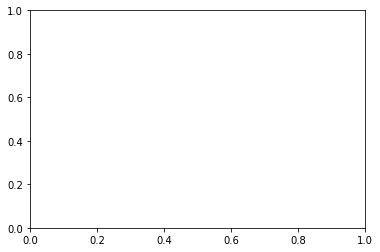

In [19]:
plt.hist(vod['time_stop'], color = 'blue', edgecolor = 'black')
         #bins = int(180/5))

# seaborn histogram
sns.distplot(vod['time_stop'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')

In [ ]:
#datetime to string (take 'time' only)
vod.Sunset = vod.Sunset.apply(lambda x: datetime.strftime(x, '%H:%M:%S'))
vod.Dusk = vod.Dusk.apply(lambda x: datetime.strftime(x, '%H:%M:%S'))
vod['stop'] = vod.timestamp.apply(lambda x: datetime.strftime(x, '%H:%M:%S'))

In [ ]:
#tring to datatime (make all the years the same to compare time)
vod.Sunset = vod.Sunset.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
vod.Dusk = vod.Dusk.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
vod.stop = vod.stop.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))

In [ ]:
#tring to datatime (make all the years the same to compare time)
vod.Sunset = vod.Sunset.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
vod.Dusk = vod.Dusk.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
vod.stop = vod.stop.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
#chosen inter-twilight period
set_start = datetime(1900, 1, 1, 18, 45, 0)
set_stop = datetime(1900, 1, 1, 19, 0, 0)
#Stop time is between the chosen period
vod = vod[vod.stop >= set_start]
vod = vod[vod.stop <= set_stop]

#Stop time is NOT between the inter-twilight period of that day (should be neither dark or bright)
bright = vod[list(vod.stop <= vod.Sunset)]
dark = vod[list(vod.stop >= vod.Dusk)]

#Whether the stop time is before sunset or not (bright or not)
#vod['Bright'] = list(vod.stop <= vod.Sunset)


(bright.subject_race == 'Black/African American').mean()


(dark.subject_race == 'Black/African American').mean()

In [ ]:
#Stop time is between the chosen period
vod = vod[vod.stop >= set_start]
vod = vod[vod.stop <= set_stop]

#Stop time is NOT between the inter-twilight period of that day (should be neither dark or bright)
bright = vod[list(vod.stop <= vod.Sunset)]
dark = vod[list(vod.stop >= vod.Dusk)]

#Whether the stop time is before sunset or not (bright or not)
#vod['Bright'] = list(vod.stop <= vod.Sunset)

In [ ]:
(bright.subject_race == 'Black/African American').mean()

In [ ]:
(dark.subject_race == 'Black/African American').mean()